# Longitude, Latitude, Tilt and Azimuth Estimation Example

_Bennet Meyers, Alejandro Londono
06/29/2021

This notebook demonstrates the usage of the `ConfigurationEstimator` class to estimate latitude, longitude, tilt and azimuth from field data. NIST provides data from a collection of fully instrumented and documented arrays installed at their Maryland campus. These arrays have known latitude, longitude, tilt, and azimuth parameters. The data is publicly available [here](https://doi.org/10.18434/M3S67G), and documentation of the systems is provided [here](http://dx.doi.org/10.6028/NIST.TN.1896). In preparation for this work, I downloaded the available data, which is provided in daily CSV files cover a time span of 4 years, separated by system (ground, canopy, roof, and the two meteorological stations). I extracted the power and irradiance columns from these 6937 individual CSV files, and combined them to generate a single table spanning four years. The resulting `pickle` file is about 1.1GB in size, and is available from [my personal OneDrive](https://office365stanford-my.sharepoint.com/:u:/g/personal/bennetm_stanford_edu/EZ6bR4CFT8BJoa6NHG8y6jEBnGwR5IKf7W0CTic-RCph-g?e=8VoEj3).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Standard Imports
import pandas as pd
from geopy.distance import great_circle
from glob import glob
from time import time
# Solar Data Tools imports
from solardatatools import DataHandler
# pv-system-profiler imports
import sys
sys.path.append('..')
sys.path.append('../../Documents/github/pv-system-profiler')
from pvsystemprofiler.estimator import ConfigurationEstimator

# Configuration information from the published documentation:

In [3]:
ground_system_configuration = {
    'longitude': -77.2141,
    'latitude': 39.1319,
    'tilt': 20,
    'azimuth': 0,
}

# Load in 4-year data file, derived from NIST CSV files.

In [4]:
try:
    df = pd.read_pickle('~/pvinsight/scripts/data/NIST_all_power_and_irradiance_with_current.pkl')
except FileNotFoundError:
    print('Please download example data file to working directory')

# Utilize standard `solar-data-tools` preprocessing pipeline.

## Using AC power signal

total time: 40.11 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              22.11s
Cleaning                   14.62s
Filtering/Summarizing      3.37s
    Data quality           0.77s
    Clear day detect       0.43s
    Clipping detect        0.34s
    Capacity change detect 1.82s

Length:                4.00 years
Capacity estimate:     30.13 kW
Data sampling:         1.0 minute
Data quality score:    92.1%
Data clearness score:  15.7%
Inverter clipping:     False
Time shifts corrected: True
Time zone correction:  None


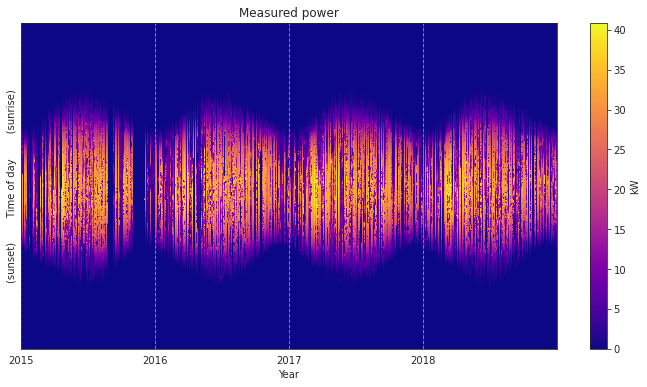

In [5]:
dh_dc_current = DataHandler(df)
dh_dc_current.run_pipeline(power_col= ('ground', 'ShuntCurrent_A_Avg_4'), verbose=False)
dh_ac_power = DataHandler(df)
dh_ac_power.run_pipeline(power_col=('ground', 'ShuntPDC_kW_Avg_4'))
dh_ac_power.report()
dh_ac_power.plot_heatmap(matrix='filled');

# Initialize estimator class with the data handler instance and timezone information.

In [6]:
est_power = ConfigurationEstimator(dh_ac_power, gmt_offset=-5)
est_current = ConfigurationEstimator(dh_dc_current, gmt_offset=-5)

# Estimate longitude using default keyboard arguments:

In [7]:
est = est_power
est.estimate_longitude()
lon = est.longitude

m1 = 'Real Longitude:  {:.2f}\n'.format(ground_system_configuration['longitude'])
m1 += 'Estimated Longitude:  {:.2f}\n'.format(est.longitude)
m1 += 'error:       {:.2f}'.format(ground_system_configuration['longitude'] - est.longitude)
print(m1)

Real Longitude:  -77.21
Estimated Longitude:  -77.52
error:       0.31


# Estimate latitude using default keyboard arguments

In [8]:
est = est_power
est.estimate_latitude()

m1 = 'Real Latitude:  {:.2f}\n'.format(ground_system_configuration['latitude'])
m1 += 'Estimated  Latitude:  {:.2f}\n'.format(est.latitude)
m1 += 'error:       {:.2f}'.format(ground_system_configuration['latitude'] - est.latitude)
print(m1)

Real Latitude:  39.13
Estimated  Latitude:  43.04
error:       -3.91


# Estimate tilt and azimuth with known values of longitude and latitude 

In [9]:
est = est_current
est.estimate_orientation(longitude=ground_system_configuration['longitude'], 
                         latitude=ground_system_configuration['latitude'])
m1 = 'Real tilt:  {:.2f}\n'.format(ground_system_configuration['tilt'])
m1 += 'Estimated Tilt:  {:.2f}\n'.format(est.tilt)
m1 += 'error tilt:   {:.2f}\n'.format(ground_system_configuration['tilt'] - est.tilt)
m1 += 'Real azimuth:   {:.2f}\n'.format(ground_system_configuration['azimuth'])
m1 += 'Estimated azim:   {:.2f}\n'.format(est.azimuth)
m1 += 'error azim:   {:.2f}'.format(ground_system_configuration['azimuth'] - est.azimuth)
print(m1)

Real tilt:  20.00
Estimated Tilt:  21.61
error tilt:   -1.61
Real azimuth:   0.00
Estimated azim:   -0.49
error azim:   0.49


# Estimate all location and orientation parameters

In [10]:
est = est_power
est.estimate_all()

m1 = 'real lon:  {:.2f}\n'.format(ground_system_configuration['longitude'])
m1 += 'est  lon:  {:.2f}\n'.format(est.longitude)
m1 += 'error lon: {:.2f}\n'.format(ground_system_configuration['longitude'] - est.longitude)
m1 += 'real lat:  {:.2f}\n'.format(ground_system_configuration['latitude'])
m1 += 'est  lat:  {:.2f}\n'.format(est.latitude)
m1 += 'error lat: {:.2f}\n'.format(ground_system_configuration['latitude'] - est.latitude)
m1 += 'Real tilt:  {:.2f}\n'.format(ground_system_configuration['tilt'])
m1 += 'Estimated Tilt: {:.2f}\n'.format(est.tilt)
m1 += 'error tilt: {:.2f}\n'.format(ground_system_configuration['tilt'] - est.tilt)
m1 += 'Real azimuth: {:.2f}\n'.format(ground_system_configuration['azimuth'])
m1 += 'Estimated azim: {:.2f}\n'.format(est.azimuth)
m1 += 'error azim: {:.2f}'.format(ground_system_configuration['azimuth'] - est.azimuth)
print(m1)

real lon:  -77.21
est  lon:  -77.52
error lon: 0.31
real lat:  39.13
est  lat:  43.04
error lat: -3.91
Real tilt:  20.00
Estimated Tilt: 38.29
error tilt: -18.29
Real azimuth: 0.00
Estimated azim: -3.46
error azim: 3.46


# Estimate longitude using Haghdadi's published method of taking the median of daily estimates:

In [11]:
est = est_power

In [12]:
est.estimate_longitude(estimator='calculated', eot_calculation=('da_rosa'))
lon = est.longitude
m1 = 'real lon:  {:.2f}\n'.format(ground_system_configuration['longitude'])
m1 += 'est  lon:  {:.2f}\n'.format(est.longitude)
m1 += 'error:       {:.2f}'.format(ground_system_configuration['longitude'] - est.longitude)
print(m1)

real lon:  -77.21
est  lon:  -77.52
error:       0.31
